In [1]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd

from razdel import tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from collections import defaultdict, Counter
import re
%matplotlib inline

In [2]:
pos = pd.read_csv('data/archive/positive.csv', 
                  sep=';', 
                  header=None, 
                  usecols=[3], 
                  names=['text']) #names=['id', 'id2', 'nick', 'text', 'meta1', 'meta2', 'meta3', 'meta4', 'meta5', 'meta6', 'meta7', 'meta8'] )
pos['label'] = 1

In [3]:
neg = pd.read_csv('data/archive/negative.csv', sep=';', header=None, usecols=[3], names=['text']) 
neg['label'] = 0

In [4]:
full_ds = pd.concat((pos, neg))
full_ds['tokenized'] = full_ds.apply(lambda row: [t.text for t in tokenize(row['text'])], axis=1)

In [5]:
train_ds, test_ds = train_test_split(full_ds, test_size=0.2)

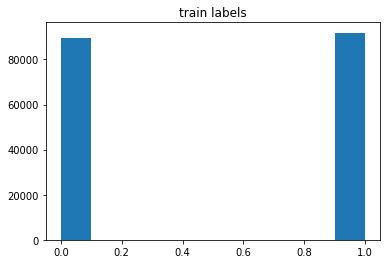

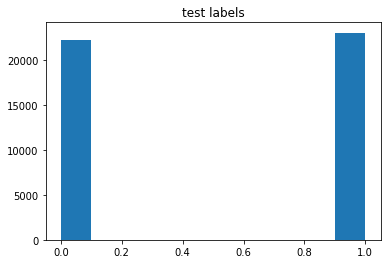

In [6]:
plt.hist(train_ds['label'])
plt.title('train labels')
plt.show()
plt.hist(test_ds['label'])
plt.title('test labels')
plt.show()

Обучение классификатора на таких данных дает accuracy=100%. Происходит это из-за наличия скобок "(" и ")". Особенность базы в том, что скобки напрямую выражают эмоции коментария. Если есть ")", то коментарий positive, если "(" - negative. Ниже отрисованны 200 случайных примеров из тест сета. По оси X - количество "(" в тексте. По оси Y - количество ")".

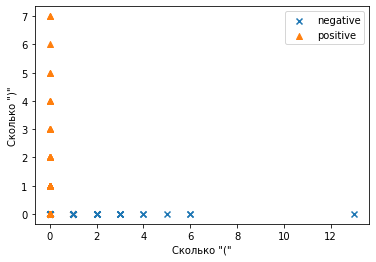

Для дальнейших экспериментов удалим все не чисто русские токены

In [7]:
rus_word = re.compile('^[а-яё\-]+$')
def remove_non_rus(splited_line):
    return [w for w in map(str.lower, splited_line) if rus_word.match(w)]

# print(remove_non_rus('Я есть грут @'.split()))
# print(remove_non_rus('Я есть грут @'.split()))
# print(remove_non_rus('Я eat грут @'.split()))
# print(remove_non_rus('Я есть грут, ё-ёё'.split()))
# print(remove_non_rus('Я есть )))) грут '.split()))

In [8]:
count_vec = CountVectorizer(tokenizer=remove_non_rus, lowercase=False, token_pattern=None, max_features=100)
train_counts = count_vec.fit_transform(train_ds['tokenized'])
test_counts = count_vec.transform(test_ds['tokenized'])

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


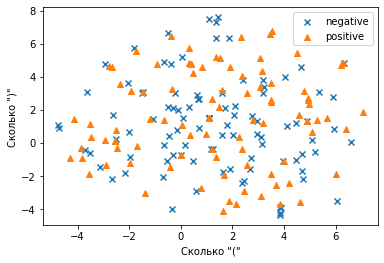

In [9]:
# t-SNE plot
def plot(embs, labels):
    embeddings = TSNE(n_components=2)
    Y = embeddings.fit_transform(embs)
    #Y = embs.toarray()
    y_0 = Y[labels==0]
    y_1 = Y[labels==1]
    plt.scatter(y_0[:, 0], y_0[:, 1], marker='x', cmap=plt.cm.Spectral)
    plt.scatter(y_1[:, 0], y_1[:, 1], marker='^', cmap=plt.cm.Spectral)
    plt.xlabel('Сколько "("')
    plt.ylabel('Сколько ")"')
    plt.legend(['negative', 'positive'])
    plt.show()
plot(test_counts[:200], test_ds['label'][:200])

In [10]:
#from sklearn.naive_bayes import MultinomialNB
nb_counts = MultinomialNB() 
nb_counts.fit(train_counts, train_ds['label'])
#knn_counts.fit(test_counts, test_ds['label'])
# KNeighborsClassifier(n_neighbors=2)
#nb_tfidf.fit(train_tfidf, train_ds['label'])


MultinomialNB()

In [11]:
print(sklearn.metrics.classification_report(test_ds['label'], nb_counts.predict(test_counts), target_names=['negative', 'positive']))


              precision    recall  f1-score   support

    negative       0.62      0.56      0.59     22296
    positive       0.61      0.67      0.64     23071

    accuracy                           0.62     45367
   macro avg       0.62      0.62      0.62     45367
weighted avg       0.62      0.62      0.62     45367



In [12]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, max_features=100)
train_tfidf = tfidf.fit_transform(train_ds['tokenized'])
test_tfidf = tfidf.transform(test_ds['tokenized'])


In [13]:
nb_tfidf = MultinomialNB() # KNeighborsClassifier(n_neighbors=2)
nb_tfidf.fit(train_tfidf, train_ds['label'])

MultinomialNB()

In [14]:
print(sklearn.metrics.classification_report(test_ds['label'], nb_tfidf.predict(test_tfidf), target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.98      0.94      0.96     22296
    positive       0.94      0.98      0.96     23071

    accuracy                           0.96     45367
   macro avg       0.96      0.96      0.96     45367
weighted avg       0.96      0.96      0.96     45367



# Нейросети

In [15]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import torchmetrics


In [16]:
class LitBase(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.lr = lr
        self.model = None
        self.criterion = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            if isinstance(x, list) and len(x) == 2 :
                x = x[0]
            else:
                print(f'{len(x)} {x[0].shape=} {x[1].shape=}')
                raise RuntimeError()
        return self.model(x)
    
    def compute_loss(self, batch, batch_idx):
        #print(batch)
        x, y = batch
        #print(f'{x.shape=} {y.shape=}')
        btz = x.shape[0]
        logits = self(x)
        #print(f'{logits.shape=}')
        loss = self.criterion(logits.view(btz, -1), y.view(btz, -1))
        return loss, logits
    
    def training_step(self, batch, batch_idx):
        # Logging to TensorBoard by default
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("val_loss", loss,  prog_bar=True)
        predicted = (logits.view(-1)>0.5).float()
        y = batch[1].view(-1)
        acc = (y == predicted).sum()/y.shape[0]
        self.log("val_acc", acc,  prog_bar=True)
        return loss
    
    def predicts_step(self, batch, batch_idx):
        x = batch[0]
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = lr_scheduler_config = {           
            "scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
            "interval": "epoch"}
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler}

class LitDNN(LitBase):
    def __init__(self, num_features, num_layers=2, dim=512,  lr=1e-4):
        super().__init__(lr=lr)
        model = []
        for i in range(num_layers): 
            model.append(nn.Linear(num_features if i == 0 else dim, 
                                   1 if i == num_layers - 1 else dim))
            if i < num_layers - 1:
                model.append(nn.ReLU())
        self.model = nn.Sequential(*model)



In [17]:
train_torch_ds = TensorDataset(torch.from_numpy(train_tfidf.toarray()).float(), 
                               torch.from_numpy(train_ds['label'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_tfidf.toarray()).float(), 
                               torch.from_numpy(test_ds['label'].values).float())

In [165]:
train_dl = DataLoader(train_torch_ds, batch_size=128, shuffle=True, num_workers=6)
test_dl = DataLoader(test_torch_ds, batch_size=128, shuffle=True, num_workers=6)
dnn = LitDNN(100, num_layers=4)
trainer = pl.Trainer(gpus=1, 
                     auto_lr_find=True, 
                     max_epochs=20, 
                     log_every_n_steps=300, 
                     default_root_dir="models/dnn")
trainer.tune(dnn, train_dl, test_dl) # fit(dnn, train_dl)
print(f"best lr is {dnn.lr}")
trainer.fit(dnn, train_dl, test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:440: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 89 steps due to diverging loss.
Restoring states from the checkpoint path at models/dnn/lr_find_temp_model_7854cd9c-37b4-44bf-b178-7ed5131eec64.ckpt
Learning rate set to 0.002754228703338169
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 577 K 
------------------------------------------------
577 K     Trainable params
0         Non-trainable params
577 K     Total params
2.310     Total estimated model params size (MB)


best lr is 0.002754228703338169


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [170]:
trainer.validate(dnn, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:440: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9729318618774414, 'val_loss': 0.2685976028442383}
--------------------------------------------------------------------------------


[{'val_loss': 0.2685976028442383, 'val_acc': 0.9729318618774414}]

In [171]:
def cls_report(model, dl):
    predict = []
    labels = []
    with torch.no_grad():
        for x, y in dl:
            p = (model(x) > 0).cpu().int()
            predict.append(p.numpy())
            labels.append(y.numpy())
    predict = np.concatenate(predict)
    labels = np.concatenate(labels)

    print(sklearn.metrics.classification_report(labels, 
                                                predict, 
                                                target_names=['negative', 'positive']))
cls_report(dnn, test_dl)

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97     22306
    positive       0.97      0.97      0.97     23061

    accuracy                           0.97     45367
   macro avg       0.97      0.97      0.97     45367
weighted avg       0.97      0.97      0.97     45367



In [18]:
class LitBLSTM(LitBase):
    def __init__(self, vocab_size, num_layers=2, dim=256, lr=1e-4, pad_id=-1):
        super().__init__(lr=lr)
        self.vocab_size=vocab_size
        self.pad_id = pad_id
        self.blstm = nn.Sequential(nn.Embedding(vocab_size, dim, padding_idx=pad_id),
                               nn.LSTM(dim, dim, batch_first=True, 
                                       bidirectional=True, num_layers=num_layers))
        
        self.head = nn.Linear(dim*2, 1)

                               
    def forward(self, x):
        #print(f"{x.shape=}")
        if x.max() >= self.vocab_size:
            print(x)
            raise RuntimeError()
        pad_mask = (x!=self.pad_id).float().unsqueeze(dim=-1)
        #print(f"{pad_mask.shape=}")
        x, _ = self.blstm(x)
        #print(f"{x.shape=}")
        #x = x.mean(dim=1)
        x = x *pad_mask
        x = x.sum(dim=1)/pad_mask.sum(dim=1)
        #print(f"{x.shape=}")
        return self.head(x)

In [19]:
class SeqDataSet:
    def __init__(self, df, vocab):
        self.df = df#['tokenized']
        self.vocab = vocab
        self.unk = vocab['<UNK>']
        self.pad = vocab['<PAD>']
        self.ys = torch.from_numpy(df['label'].values).float()
        self.xs = [[vocab[t] if t in vocab else self.unk for t in ts] for ts in df['tokenized']]
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, i):
        x = torch.LongTensor(self.xs[i])
        if len(x) == 0:
            x = torch.LongTensor([self.unk])
        y = self.ys[i]
        return x, y

    def collate_seq(self, items):
        x = nn.utils.rnn.pad_sequence([i[0] for i in items], batch_first=True, padding_value=self.pad)
        y = torch.Tensor([i[1] for i in items]) #, batch_first=True, padding_value=-1)
        return x, y

    

vocab = CountVectorizer(tokenizer=remove_non_rus, 
                        lowercase=False, token_pattern=None, max_features=1000).fit(train_ds['tokenized']).vocabulary_
vocab['<UNK>'] = max(vocab.values()) + 1 
vocab['<PAD>'] = max(vocab.values()) + 1 

train_torch_seq = SeqDataSet(train_ds, vocab)
test_torch_seq = SeqDataSet(test_ds, vocab)

In [174]:
train_dl = DataLoader(train_torch_seq, batch_size=80, num_workers=0, shuffle=True, collate_fn=train_torch_seq.collate_seq)
test_dl = DataLoader(test_torch_seq, batch_size=80, num_workers=0, shuffle=True, collate_fn=test_torch_seq.collate_seq)


In [184]:
blstm = LitBLSTM(max(vocab.values())+1, num_layers=4, pad_id=test_torch_seq.pad)

blstm(torch.LongTensor([[1,3,2],[3,4, 101]]))
blstm

LitBLSTM(
  (criterion): BCEWithLogitsLoss()
  (blstm): Sequential(
    (0): Embedding(1002, 256, padding_idx=1001)
    (1): LSTM(256, 256, num_layers=4, batch_first=True, bidirectional=True)
  )
  (head): Linear(in_features=512, out_features=1, bias=True)
)

In [185]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=20, 
                     auto_lr_find=True, 
                     log_every_n_steps=300, 
                     default_root_dir="models/blstm") #fast_dev_run=True)
#trainer.tune(blstm, train_dl, test_dl) # fit(dnn, train_dl)
print(f"best lr is {blstm.lr}")
trainer.fit(blstm, train_dl, test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | blstm     | Sequential        | 6.0 M 
2 | head      | Linear            | 513   
------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.162    Total estimated model params size (MB)


best lr is 0.0001


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:440: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [177]:
trainer.validate(blstm, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.49167898297309875, 'val_loss': 1.12092125415802}
--------------------------------------------------------------------------------


[{'val_loss': 1.12092125415802, 'val_acc': 0.49167898297309875}]

In [178]:
cls_report(blstm, test_dl)

              precision    recall  f1-score   support

    negative       0.49      1.00      0.66     22306
    positive       0.00      0.00      0.00     23061

    accuracy                           0.49     45367
   macro avg       0.25      0.50      0.33     45367
weighted avg       0.24      0.49      0.32     45367



/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [179]:
class LitCNN1d(LitBase):
    def __init__(self, vocab_size, block_channels=(32, 64, 32), kernel_size=3, pooling_stride=2, num_blocks=3, lr=1e-4, pad_id=-1):
        super().__init__(lr=lr)
        self.vocab_size=vocab_size
        self.pad_id = pad_id
        self.embs = nn.Embedding(vocab_size, block_channels[0], padding_idx=pad_id)
        cnn = []
        in_channels=block_channels[0]
        for i in range(num_blocks):
            block = []
            for out_channels in block_channels:
                block.append(nn.Conv1d(in_channels, out_channels, 
                                       kernel_size, stride=1, padding=kernel_size//2))
                block.append(nn.BatchNorm1d(out_channels))
                block.append(nn.ReLU())
                in_channels = out_channels
            cnn.append(nn.Sequential(*block))
        self.cnn = nn.ModuleList(cnn)
        self.pooling = nn.MaxPool1d(kernel_size, stride=pooling_stride)
        
        self.head = nn.Linear(32, 1)

                               
    def forward(self, x):
        #print(f"{x.shape=}")
        if x.max() >= self.vocab_size:
            print(x)
            raise RuntimeError()
        pad_mask = (x!=self.pad_id).float().unsqueeze(dim=-1)
        #print(f"{pad_mask.shape=}")
        x = self.embs(x).transpose(1,2) # b X ch X sl
        #print(f"{x.shape=}")
        for i, block in enumerate(self.cnn):
            b_out = block(x)
            #print(f"{b_out.shape=}")
            x = x + b_out
            #print(f"{x.shape=}")
            x = self.pooling(x)
        
        x = x.mean(dim=2)
        #print(f"{x.shape=}")
        return self.head(x)

In [180]:
cnn = LitCNN1d(max(vocab.values())+1, pad_id=test_torch_seq.pad)

cnn(torch.LongTensor(torch.randint(1000, size=(2, 20))))
cnn

LitCNN1d(
  (criterion): BCEWithLogitsLoss()
  (embs): Embedding(1002, 32, padding_idx=1001)
  (cnn): ModuleList(
    (0): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=

In [181]:
trainer = pl.Trainer(gpus=0, 
                     max_epochs=10, 
                     auto_lr_find=True, 
                     log_every_n_steps=300, 
                     default_root_dir="models/cnn")#, fast_dev_run=True)
#trainer.tune(cnn, train_dl, test_dl) # fit(dnn, train_dl)
print(f"best lr is {cnn.lr}")
trainer.fit(cnn, train_dl, test_dl)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1566: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | embs      | Embedding         | 32.1 K
2 | cnn       | ModuleList        | 47.2 K
3 | pooling   | MaxPool1d         | 0     
4 | head      | Linear            | 33    
------------------------------------------------
79.3 K    Trainable params
0         Non-trainable params
79.3 K    Total params
0.317     Total estimated model params size (MB)


best lr is 0.0001


Validation sanity check: 0it [00:00, ?it/s]

/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:440: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [182]:
trainer.validate(cnn, test_dl)

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6595984101295471, 'val_loss': 0.6070258021354675}
--------------------------------------------------------------------------------


[{'val_loss': 0.6070258021354675, 'val_acc': 0.6595984101295471}]

In [183]:
cls_report(cnn, test_dl)

              precision    recall  f1-score   support

    negative       0.69      0.62      0.65     22306
    positive       0.67      0.73      0.70     23061

    accuracy                           0.68     45367
   macro avg       0.68      0.68      0.68     45367
weighted avg       0.68      0.68      0.68     45367

